In [32]:
import pandas as pd
from itertools import combinations
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
# from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import timedelta

In [33]:
df = pd.read_csv("../data/csv/Gold_Data.csv",index_col="Business_Week")
# print(len(df.columns),len(df.index))

In [34]:
df = df.drop(df.columns[0],axis=1)
df = df.drop(df.columns[9],axis=1)
df = df.dropna(axis=1)
df = df.dropna()
# print(len(df.columns),len(df.index))

In [35]:
# df.iloc[25:30]

In [36]:
# Freq is very important, specifies when and how often data is taken.
# VAR will not work without.
df["Date"] = pd.to_datetime(df["Date"],infer_datetime_format=True)
df = df.reset_index(drop=True)
for i in range(len(df["Date"])):
    if df["Date"][i].weekday() != 1:
#         print(df["Date"][i])
        try:
            df.at[i,"Date"] = df["Date"][i-1]+timedelta(days=7)
#             print(df["Date"][i])
#             print(df["Date"][i].weekday())
        except:
            df.at[i,"Date"] = df["Date"][i+1]-timedelta(days=7)
# print(df.iloc[29,:])
df.set_index("Date",inplace=True)
df = df.asfreq("W-TUE")

In [37]:
df = df.dropna()
# len(df.index)

In [38]:
len(list(df.columns))

17

In [39]:
check_columns = list(df.columns)
check_columns.remove("Gold_Settle")

In [40]:
test_columns = [list(combination) for combination in combinations(check_columns,12)]
test_results = [coint_johansen(df[combination],-1,1) for combination in test_columns]

In [41]:
# len(test_results[12].evec)

In [42]:
# test_results[12].lr1

In [43]:
# test_results[12].cvt

In [44]:
cointegration_ranking = [sum([1 if result.lr1[i] >= result.cvt[i][2] else 0 for i in range(12)]) for result in test_results]

In [45]:
# Will break if all 12 features tested have cointegration, this is real unlikely though.
highest_coint_rank = max(cointegration_ranking)
# print(highest_coint_rank)
coint_info_index = cointegration_ranking.index(highest_coint_rank)
coint_vectors = [test_columns[coint_info_index].copy(),list(test_results[coint_info_index].evec[highest_coint_rank])]
# print(len(coint_vectors[0]))
for i in range(11,highest_coint_rank,-1):
    coint_vectors[0].pop(i)
    coint_vectors[1].pop(i)

In [46]:
modulated_series = [df[coint_vectors[0][i]]*coint_vectors[1][i] for i in range(highest_coint_rank+1)]

In [47]:
stationary_series = modulated_series.pop(0)
for series in modulated_series:
    stationary_series += series

In [48]:
df["Stationary_Conglomerate"] = stationary_series

In [49]:
df.drop(coint_vectors[0],axis=1,inplace=True)

In [50]:
df.tail()

,Gold_Settle,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Prev. Day Open Interest,USD_Settle,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle,Stationary_Conglomerate
Date,,,,,,,,
2019-06-25,1392.580,190731.0,3829693.6,95.9146,46420.0,-0.19175,14.48855,-1.316646
2019-07-02,1406.920,205037.0,3782872.2,95.9638,43682.4,-0.28325,14.27985,-1.082013
2019-07-09,1405.375,207701.0,3749954.5,96.7262,41304.8,0.05575,14.24630,-2.446835
2019-07-16,1411.220,211517.0,3759147.8,96.6758,42843.8,-0.21575,14.05680,-0.513137
2019-07-23,1425.340,217199.0,3796138.0,96.8954,41641.0,-0.05900,13.99895,2.832372


In [51]:
scaler = MinMaxScaler()

In [52]:
normalized_df = scaler.fit_transform(df)
normalized_df = pd.DataFrame(normalized_df,index=df.index,columns=df.columns)
normalized_df.tail()

,Gold_Settle,Producer/Merchant/Processor/User Shorts,Ten_Yr_Futures_Prev. Day Open Interest,USD_Settle,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle,Stationary_Conglomerate
Date,,,,,,,,
2019-06-25,0.642375,0.413292,0.833242,0.772377,0.257492,0.346381,0.770509,0.611633
2019-07-02,0.653581,0.461023,0.819600,0.773950,0.236145,0.307765,0.750169,0.615486
2019-07-09,0.652374,0.469911,0.810009,0.798327,0.217605,0.450834,0.746900,0.593073
2019-07-16,0.656941,0.482642,0.812688,0.796716,0.229606,0.336252,0.728432,0.624829
2019-07-23,0.667974,0.501600,0.823465,0.803737,0.220226,0.402406,0.722794,0.679770


In [53]:
train = normalized_df.iloc[:int(.98*(len(normalized_df.index)))]
test = normalized_df.iloc[int(.02*(len(normalized_df.index))):]

In [54]:
model = VAR(endog=train)

In [55]:
fit_model = model.fit(maxlags=15, ic='aic')

In [56]:
fit_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 30, Jul, 2019
Time:                     19:04:38
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -47.9363
Nobs:                     657.000    HQIC:                  -51.7172
Log likelihood:           11221.6    FPE:                3.24965e-24
AIC:                     -54.1111    Det(Omega_mle):     9.12923e-25
--------------------------------------------------------------------
Results for equation Gold_Settle
                                                 coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------------
const                                               0.045074         0.070934            0.635           0.525
L1.Gold_Settle                               

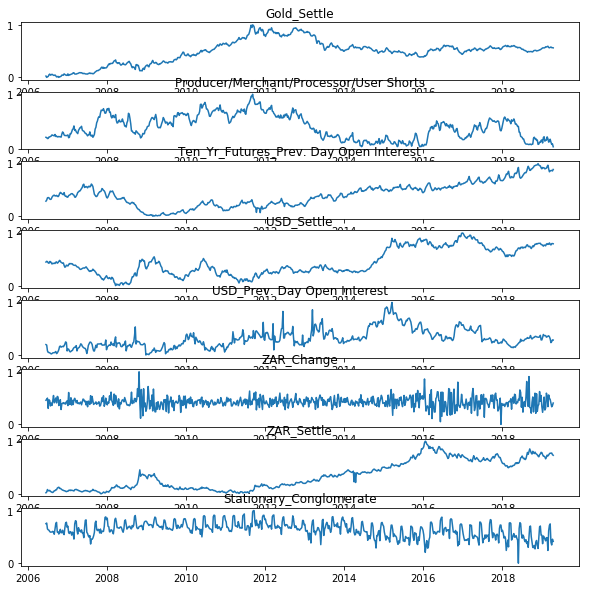

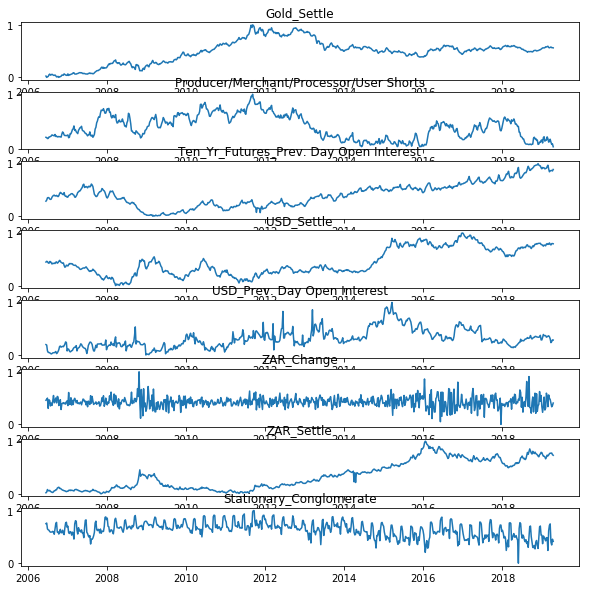

In [57]:
fit_model.plot()

In [58]:
predictions = fit_model.forecast(fit_model.y,steps=len(test.index))
predictions = pd.DataFrame(predictions,index=test.index,columns=test.columns)

In [59]:
for column in predictions.columns:
    print(f"RMSE for {column} is : {sqrt(mean_squared_error(test[column],predictions[column]))}")

RMSE for Gold_Settle is : 0.3602129017437114
RMSE for Producer/Merchant/Processor/User Shorts is : 0.5190337537663231
RMSE for Ten_Yr_Futures_Prev. Day Open Interest is : 0.7666661229481995
RMSE for USD_Settle is : 0.7189883094891799
RMSE for USD_Prev. Day Open Interest is : 0.20711102020826125
RMSE for ZAR_Change is : 0.10539438358339606
RMSE for ZAR_Settle is : 0.8007206324726337
RMSE for Stationary_Conglomerate is : 0.3099245849288596


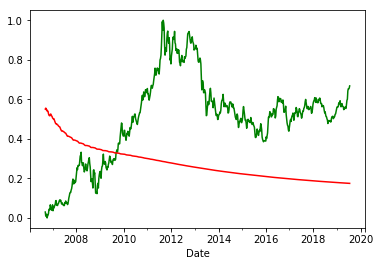

In [60]:
ax1 = test["Gold_Settle"].plot(color="green")
ax2 = predictions["Gold_Settle"].plot(color="red")

In [31]:
predictions["Gold_Settle"]

Date
2016-12-13    0.459949
2016-12-20    0.463114
2016-12-27    0.456797
2017-01-03    0.435828
2017-01-10    0.450107
2017-01-17    0.459293
2017-01-24    0.448690
2017-01-31    0.450434
2017-02-07    0.447512
2017-02-14    0.435443
2017-02-21    0.447651
2017-02-28    0.448067
2017-03-07    0.451888
2017-03-14    0.449242
2017-03-21    0.443423
2017-03-28    0.436031
2017-04-04    0.437389
2017-04-11    0.442723
2017-04-18    0.441904
2017-04-25    0.439824
2017-05-02    0.441370
2017-05-09    0.445724
2017-05-16    0.443407
2017-05-23    0.450306
2017-05-30    0.448320
2017-06-06    0.450905
2017-06-13    0.448612
2017-06-20    0.445339
2017-06-27    0.443699
2017-07-04    0.442185
                ...   
2019-01-01    0.401481
2019-01-08    0.400910
2019-01-15    0.400669
2019-01-22    0.400137
2019-01-29    0.399615
2019-02-05    0.399273
2019-02-12    0.399491
2019-02-19    0.400540
2019-02-26    0.401564
2019-03-05    0.401987
2019-03-12    0.401226
2019-03-19    0.399391
2019-0